## import libraries

In [1]:
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
import matplotlib.pyplot as plt
import os
from tensorflow.keras.metrics import Precision, Recall, MeanIoU
from tensorflow.keras.optimizers import Adam, Nadam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.applications import *
from warnings import filterwarnings
filterwarnings("ignore")
print("libraries are imported")

libraries are imported


# get data and prepare

In [2]:
df_train = pd.read_csv("../input/trains/df_train").drop(["Unnamed: 0"],axis=1)
df_valid = pd.read_csv("../input/trains/df_test").drop(["Unnamed: 0"],axis=1)

In [3]:
df_train["mask_type"] = df_train["mask_type"].replace("kanama","hemorrhage")
df_train["mask_type"] = df_train["mask_type"].replace("iskemi","ischemic")

df_valid["mask_type"] = df_valid["mask_type"].replace("kanama","hemorrhage")
df_valid["mask_type"] = df_valid["mask_type"].replace("iskemi","ischemic")

In [4]:
df_train = df_train[(df_train["mask_type"]!="ischemic") & (df_train["mask_type"]!="normal")].reset_index(drop = True)
df_valid = df_valid[(df_valid["mask_type"] != "ischemic") & (df_valid["mask_type"]!="normal")].reset_index(drop = True)

In [5]:
df_train.head()

,image_path,mask_path,mask_type,mask_status
0,/kaggle/input/yarma-verisi/TRAINING/TRAINING/K...,/kaggle/input/yarma-verisi/TRAINING/TRAINING/K...,hemorrhage,1
1,/kaggle/input/yarma-verisi/TRAINING/TRAINING/K...,/kaggle/input/yarma-verisi/TRAINING/TRAINING/K...,hemorrhage,1
2,/kaggle/input/yarma-verisi/TRAINING/TRAINING/K...,/kaggle/input/yarma-verisi/TRAINING/TRAINING/K...,hemorrhage,1
3,/kaggle/input/yarma-verisi/TRAINING/TRAINING/K...,/kaggle/input/yarma-verisi/TRAINING/TRAINING/K...,hemorrhage,1
4,/kaggle/input/yarma-verisi/TRAINING/TRAINING/K...,/kaggle/input/yarma-verisi/TRAINING/TRAINING/K...,hemorrhage,1


In [6]:
df_valid.head()

,image_path,mask_path,mask_type,mask_status
0,/kaggle/input/yarma-verisi/TRAINING/TRAINING/K...,/kaggle/input/yarma-verisi/TRAINING/TRAINING/K...,hemorrhage,1
1,/kaggle/input/yarma-verisi/TRAINING/TRAINING/K...,/kaggle/input/yarma-verisi/TRAINING/TRAINING/K...,hemorrhage,1
2,/kaggle/input/yarma-verisi/TRAINING/TRAINING/K...,/kaggle/input/yarma-verisi/TRAINING/TRAINING/K...,hemorrhage,1
3,/kaggle/input/yarma-verisi/TRAINING/TRAINING/K...,/kaggle/input/yarma-verisi/TRAINING/TRAINING/K...,hemorrhage,1
4,/kaggle/input/yarma-verisi/TRAINING/TRAINING/K...,/kaggle/input/yarma-verisi/TRAINING/TRAINING/K...,hemorrhage,1


In [7]:
df = pd.concat([df_valid,df_train],axis=0).sample(frac=1).reset_index(drop = True)
df.head()

,image_path,mask_path,mask_type,mask_status
0,/kaggle/input/yarma-verisi/TRAINING/TRAINING/K...,/kaggle/input/yarma-verisi/TRAINING/TRAINING/K...,hemorrhage,1
1,/kaggle/input/yarma-verisi/TRAINING/TRAINING/K...,/kaggle/input/yarma-verisi/TRAINING/TRAINING/K...,hemorrhage,1
2,/kaggle/input/yarma-verisi/TRAINING/TRAINING/K...,/kaggle/input/yarma-verisi/TRAINING/TRAINING/K...,hemorrhage,1
3,/kaggle/input/yarma-verisi/TRAINING/TRAINING/K...,/kaggle/input/yarma-verisi/TRAINING/TRAINING/K...,hemorrhage,1
4,/kaggle/input/yarma-verisi/TRAINING/TRAINING/K...,/kaggle/input/yarma-verisi/TRAINING/TRAINING/K...,hemorrhage,1


# Vizualizing

1041
703
292


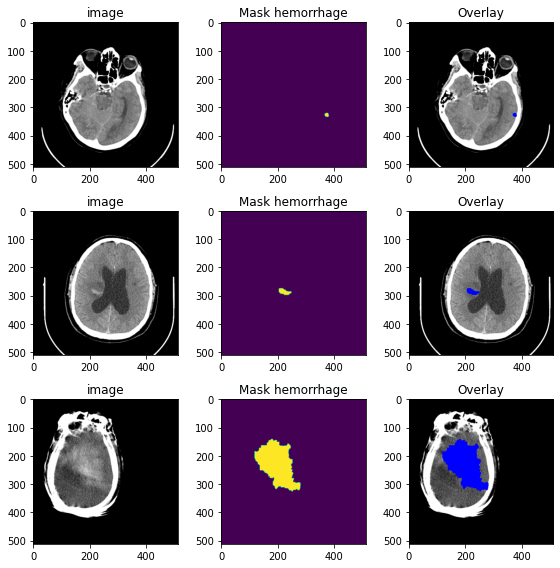

In [8]:
count = 0
fig, axs = plt.subplots(3,3, figsize=(8,8))

for i in range(len(df)):
    if  count<3:
    
        #read  images
        rnd = np.random.randint(0,len(df))
        img = cv2.imread(df.loc[rnd,"image_path"],1)
        img = cv2.resize(img,(512,512))
        axs[count][0].imshow(img)
        print(rnd)
        axs[count][0].title.set_text('image')
        
        #read  mask
        mask = cv2.imread(df.loc[rnd,"mask_path"],0)
        axs[count][1].imshow(mask)
        label = df.loc[rnd,"mask_type"]

        axs[count][1].title.set_text('Mask '+label)

        mask = cv2.resize(mask,(512,512))
        s = np.where((mask.reshape(512,512,1) == np.max(mask)).any(axis=2))
        color = (0,0,255)
        img[s] = color
        axs[count][2].imshow(img)
        axs[count][2].title.set_text('Overlay')

        count +=1
    if (count==3):
        break

fig.tight_layout() 

## preprocessed image  vizualizing

113
203
847


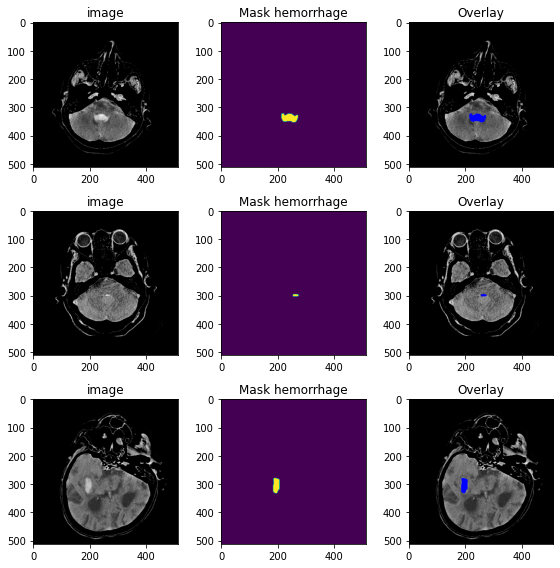

In [9]:
count = 0
fig, axs = plt.subplots(3,3, figsize=(8,8))

for i in range(len(df)):
    if  count<3:
        #read  images
        rnd = np.random.randint(0,len(df))
        img = cv2.imread(df.loc[rnd,"image_path"],1)
        img = cv2.resize(img,(512,512))
        img[np.where((img == (255,255,255)).all(axis=2))] = (0,0,0)
        axs[count][0].imshow(img)
        print(rnd)
        axs[count][0].title.set_text('image')
        
        #read original mask
        mask = cv2.imread(df.loc[rnd,"mask_path"],0)
        axs[count][1].imshow(mask)
        label = df.loc[rnd,"mask_type"]

        axs[count][1].title.set_text('Mask '+label)
        mask = cv2.resize(mask,(512,512))
        s = np.where((mask.reshape(512,512,1) == np.max(mask)).any(axis=2))
       
        color = (0,0,255)
        img[s] = color
        axs[count][2].imshow(img)
        axs[count][2].title.set_text('Overlay')
        
        count +=1
    if (count==3):
        break

fig.tight_layout() 

# train-test split

In [10]:
df_train, df_valid = train_test_split(df, test_size = 0.1, random_state = 1)

In [11]:
f" size of train: {len(df_train)}, size of valid: {len(df_valid)}"

' size of train: 983, size of valid: 110'

In [12]:
df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)

In [13]:
df_train.head()

,image_path,mask_path,mask_type,mask_status
0,/kaggle/input/yarma-verisi/TRAINING/TRAINING/K...,/kaggle/input/yarma-verisi/TRAINING/TRAINING/K...,hemorrhage,1
1,/kaggle/input/yarma-verisi/TRAINING/TRAINING/K...,/kaggle/input/yarma-verisi/TRAINING/TRAINING/K...,hemorrhage,1
2,/kaggle/input/yarma-verisi/TRAINING/TRAINING/K...,/kaggle/input/yarma-verisi/TRAINING/TRAINING/K...,hemorrhage,1
3,/kaggle/input/yarma-verisi/TRAINING/TRAINING/K...,/kaggle/input/yarma-verisi/TRAINING/TRAINING/K...,hemorrhage,1
4,/kaggle/input/yarma-verisi/TRAINING/TRAINING/K...,/kaggle/input/yarma-verisi/TRAINING/TRAINING/K...,hemorrhage,1


In [14]:
df_valid.head()

,image_path,mask_path,mask_type,mask_status
0,/kaggle/input/yarma-verisi/TRAINING/TRAINING/K...,/kaggle/input/yarma-verisi/TRAINING/TRAINING/K...,hemorrhage,1
1,/kaggle/input/yarma-verisi/TRAINING/TRAINING/K...,/kaggle/input/yarma-verisi/TRAINING/TRAINING/K...,hemorrhage,1
2,/kaggle/input/yarma-verisi/TRAINING/TRAINING/K...,/kaggle/input/yarma-verisi/TRAINING/TRAINING/K...,hemorrhage,1
3,/kaggle/input/yarma-verisi/TRAINING/TRAINING/K...,/kaggle/input/yarma-verisi/TRAINING/TRAINING/K...,hemorrhage,1
4,/kaggle/input/yarma-verisi/TRAINING/TRAINING/K...,/kaggle/input/yarma-verisi/TRAINING/TRAINING/K...,hemorrhage,1


# prepare data

In [15]:
class DataGen(Sequence):
    def __init__(self, image_size, images_path, masks_path, batch_size=5):
        self.image_size = image_size
        self.images_path = images_path
        self.masks_path = masks_path
        self.batch_size = batch_size
        self.on_epoch_end()

    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.images_path):
            self.batch_size = len(self.images_path) - index*self.batch_size

        images_path = self.images_path[index*self.batch_size : (index+1)*self.batch_size]
        masks_path = self.masks_path[index*self.batch_size : (index+1)*self.batch_size]

        images_batch = []
        masks_batch = []

        for i in range(len(images_path)):
            ## Read image and mask
            image = cv2.imread(images_path[i],1)
            image = cv2.resize(image,(512,512))
            image[(image==(255,255,255)).all(axis=2)] = (0,0,0)
            image = image/255
            mask = cv2.imread(masks_path[i],0)
            mask = cv2.resize(mask,(512,512))
            mask = np.expand_dims(mask, -1)
            mask = mask/2
            images_batch.append(image)
            mask = np.array(mask,dtype = "float")
            
            masks_batch.append(mask)

        return np.array(images_batch), np.array(masks_batch)

    def on_epoch_end(self):
        pass

    def __len__(self):
        return int(np.ceil(len(self.images_path)/float(self.batch_size)))

In [16]:
batch_size = 5
train_gen = DataGen(512, df_train.loc[:,"image_path"].values, df_train.loc[:,"mask_path"].values, batch_size=batch_size)
valid_gen = DataGen(512, df_valid.loc[:,"image_path"].values, df_valid.loc[:,"mask_path"].values, batch_size=batch_size)

In [17]:
train_steps = len(df_train.loc[:,"image_path"].values)//batch_size
valid_steps = len(df_valid.loc[:,"image_path"].values)//batch_size

## Model

In [18]:
def squeeze_excite_block(inputs, ratio=8):
    init = inputs
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = Multiply()([init, se])
    return x

def stem_block(x, n_filter, strides):
    x_init = x

    ## Conv 1
    x = Conv2D(n_filter, (3, 3), padding="same", strides=strides)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(n_filter, (3, 3), padding="same")(x)

    ## Shortcut
    s  = Conv2D(n_filter, (1, 1), padding="same", strides=strides)(x_init)
    s = BatchNormalization()(s)

    ## Add
    x = Add()([x, s])
    x = squeeze_excite_block(x)
    return x


def resnet_block(x, n_filter, strides=1):
    x_init = x

    ## Conv 1
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(n_filter, (3, 3), padding="same", strides=strides)(x)
    ## Conv 2
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(n_filter, (3, 3), padding="same", strides=1)(x)

    ## Shortcut
    s  = Conv2D(n_filter, (1, 1), padding="same", strides=strides)(x_init)
    s = BatchNormalization()(s)

    ## Add
    x = Add()([x, s])
    x = squeeze_excite_block(x)
    return x

def aspp_block(x, num_filters, rate_scale=1):
    x1 = Conv2D(num_filters, (3, 3), dilation_rate=(6 * rate_scale, 6 * rate_scale), padding="same")(x)
    x1 = BatchNormalization()(x1)

    x2 = Conv2D(num_filters, (3, 3), dilation_rate=(12 * rate_scale, 12 * rate_scale), padding="same")(x)
    x2 = BatchNormalization()(x2)

    x3 = Conv2D(num_filters, (3, 3), dilation_rate=(18 * rate_scale, 18 * rate_scale), padding="same")(x)
    x3 = BatchNormalization()(x3)

    x4 = Conv2D(num_filters, (3, 3), padding="same")(x)
    x4 = BatchNormalization()(x4)

    y = Add()([x1, x2, x3, x4])
    y = Conv2D(num_filters, (1, 1), padding="same")(y)
    return y

def attetion_block(g, x):
    """
        g: Output of Parallel Encoder block
        x: Output of Previous Decoder block
    """

    filters = x.shape[-1]

    g_conv = BatchNormalization()(g)
    g_conv = Activation("relu")(g_conv)
    g_conv = Conv2D(filters, (3, 3), padding="same")(g_conv)

    g_pool = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(g_conv)

    x_conv = BatchNormalization()(x)
    x_conv = Activation("relu")(x_conv)
    x_conv = Conv2D(filters, (3, 3), padding="same")(x_conv)

    gc_sum = Add()([g_pool, x_conv])

    gc_conv = BatchNormalization()(gc_sum)
    gc_conv = Activation("relu")(gc_conv)
    gc_conv = Conv2D(filters, (3, 3), padding="same")(gc_conv)

    gc_mul = Multiply()([gc_conv, x])
    return gc_mul

class ResUnetPlusPlus:
    def __init__(self, input_size=512):
        self.input_size = input_size

    def build_model(self):
        n_filters = [16, 32, 64, 128, 256,512]
        inputs = Input((self.input_size, self.input_size, 3))

        c0 = inputs
        c1 = stem_block(c0, n_filters[0], strides=1)

        ## Encoder
        c2 = resnet_block(c1, n_filters[1], strides=2)
        c3 = resnet_block(c2, n_filters[2], strides=2)
        c4 = resnet_block(c3, n_filters[3], strides=2)

        ## Bridge
        b1 = aspp_block(c4, n_filters[4])

        ## Decoder
        d1 = attetion_block(c3, b1)
        d1 = UpSampling2D((2, 2))(d1)
        d1 = Concatenate()([d1, c3])
        d1 = resnet_block(d1, n_filters[3])

        d2 = attetion_block(c2, d1)
        d2 = UpSampling2D((2, 2))(d2)
        d2 = Concatenate()([d2, c2])
        d2 = resnet_block(d2, n_filters[2])

        d3 = attetion_block(c1, d2)
        d3 = UpSampling2D((2, 2))(d3)
        d3 = Concatenate()([d3, c1])
        d3 = resnet_block(d3, n_filters[1])

        ## output
        outputs = aspp_block(d3, n_filters[0])
        outputs = Conv2D(1, (1, 1), padding="same")(outputs)
        outputs = Activation("sigmoid")(outputs)

        ## Model
        model = Model(inputs, outputs)
        return model

In [19]:
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [20]:
image_size = 512
lr = 0.01
epochs = 30

In [21]:
arch = ResUnetPlusPlus(input_size=image_size)
model = arch.build_model()
checkpoint = ModelCheckpoint("segmente_model.h5", verbose=1, save_best_only=True,mode = "max", monitor = "val_mean_io_u")
reduce_lr = ReduceLROnPlateau(monitor='val_mean_io_u', factor=0.1, patience=5, min_lr=0.000001, verbose=1, mode = "max")
callbacks = [checkpoint, reduce_lr]
optimizer = Nadam(lr)
metrics = [MeanIoU(num_classes=2)]
model.compile(loss=dice_loss, optimizer=optimizer, metrics=metrics)

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 512, 512, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [23]:
model.fit(train_gen,
            validation_data=valid_gen,
            steps_per_epoch=train_steps,
            validation_steps=valid_steps,
            epochs=epochs,
            callbacks=callbacks)

Epoch 1/30
196/196 [==============================] - 124s 531ms/step - loss: 0.5716 - mean_io_u: 0.6138 - val_loss: 0.9978 - val_mean_io_u: 0.4316

Epoch 00001: val_mean_io_u improved from -inf to 0.43156, saving model to segmente_model.h5
Epoch 2/30
196/196 [==============================] - 67s 341ms/step - loss: 0.2980 - mean_io_u: 0.7667 - val_loss: 0.9284 - val_mean_io_u: 0.3768

Epoch 00002: val_mean_io_u did not improve from 0.43156
Epoch 3/30
196/196 [==============================] - 55s 283ms/step - loss: 0.3271 - mean_io_u: 0.7594 - val_loss: 0.6263 - val_mean_io_u: 0.6083

Epoch 00003: val_mean_io_u improved from 0.43156 to 0.60828, saving model to segmente_model.h5
Epoch 4/30
196/196 [==============================] - 43s 218ms/step - loss: 0.3928 - mean_io_u: 0.7097 - val_loss: 0.9999 - val_mean_io_u: 0.4945

Epoch 00004: val_mean_io_u did not improve from 0.60828
Epoch 5/30
196/196 [==============================] - 38s 192ms/step - loss: 0.3749 - mean_io_u: 0.7220 - va

# Results

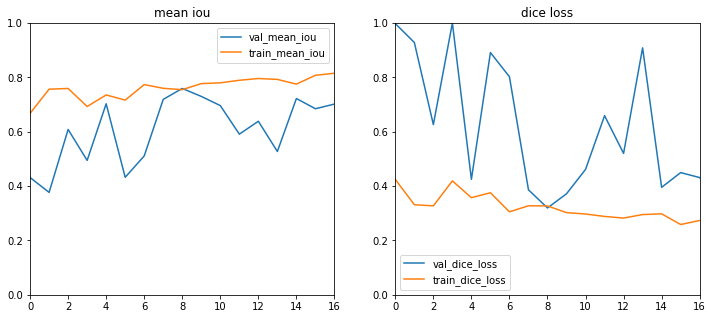

In [24]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(model.history.history["val_mean_io_u"],label = "val_mean_iou")
plt.plot(model.history.history["mean_io_u"],label = "train_mean_iou")
plt.legend()
plt.xlim(0, 16)
plt.ylim(0,1)
plt.title("mean iou")
plt.subplot(1,2,2)
plt.plot(model.history.history["val_loss"],label = "val_dice_loss")
plt.plot(model.history.history["loss"],label = "train_dice_loss")
plt.title("dice loss")
plt.legend()
plt.xlim(0, 16)
plt.ylim(0,1)
plt.savefig("results.png")
plt.show()

# Prediction

In [25]:
model = load_model("./segmente_model.h5", custom_objects = {"dice_loss":dice_loss})

45
103
29


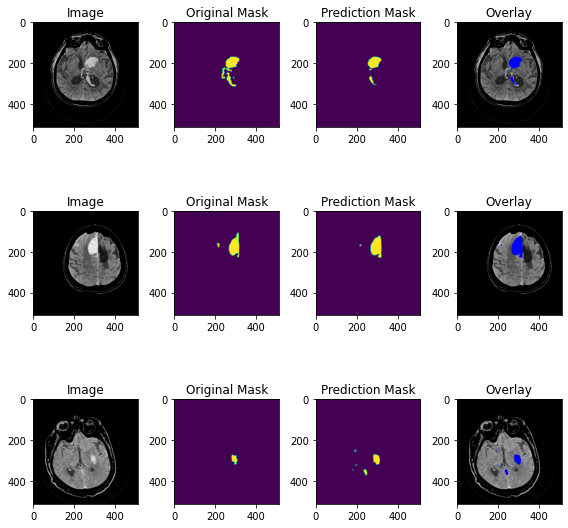

In [36]:
count = 0
fig, axs = plt.subplots(3,4, figsize=(8,8))

for i in range(len(df_valid)):
    if  count<3:
        #read  images
        rnd = np.random.randint(0,len(df_valid))
        img = cv2.imread(df_valid.loc[rnd,"image_path"],1)
        img = cv2.resize(img,(512,512))
        img[np.where((img == (255,255,255)).all(axis=2))] = (0,0,0)
        axs[count][0].imshow(img)
        print(rnd)
        axs[count][0].title.set_text('Image')
        
        #read original mask
        mask = cv2.imread(df_valid.loc[rnd,"mask_path"],0)
        axs[count][1].imshow(mask)
        axs[count][1].title.set_text("Original Mask")
        
        # prediction mask
        pred = model.predict(img.reshape((1, 512, 512, 3))/255).round()[0]                             
        mask = cv2.resize(pred,(512,512))
        axs[count][2].imshow(pred)
        axs[count][2].title.set_text('Prediction Mask')
        
                                     
        # overlay
        s = np.where((pred.reshape(512,512,1) == np.max(pred)).any(axis=2))
       
        color = (0,0,255)
        img[s] = color
                                  
        axs[count][3].imshow(img)
        axs[count][3].title.set_text('Overlay')                             
        
        count +=1
    if (count==3):
        break

fig.tight_layout() 